In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../python/')

In [2]:
import random
import via as VIA

from torch.utils.data import DataLoader
from dataset import VIADataset, ToTensor

via = VIA.load('../products/json/california.json')

keys = sorted(list(via.keys()))

random.seed(0)
random.shuffle(keys)

valid_via = {key: via[key] for i, key in enumerate(keys) if (i % 5) == 1} # fold 1
validset = ToTensor(VIADataset(valid_via, '../resources/california/', shuffle=True))
validloader = DataLoader(validset, batch_size=10)

# Multi-Task U-Net

`MultiTaskUNet` was trained with the `MultiTaskLoss` loss function for `40` epochs.

In [3]:
import torch
from torchsummary import summary
from models import MultiTaskUNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskUNet(3, 1, R=5).to(device)
model.load_state_dict(torch.load('../products/models/multiunet_1_020.pth', map_location=device))

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

## Training

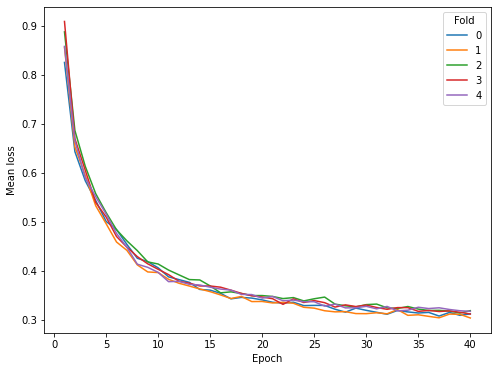

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

stats = pd.read_csv('../products/csv/multiunet.csv')

plt.figure(figsize=(8, 6))

for i in range(5):
    plt.plot(
        stats[stats['model'] == 'multiunet_{}'.format(i)]['epoch'],
        stats[stats['model'] == 'multiunet_{}'.format(i)]['train_loss_mean'],
        label='{}'.format(i)
    )

plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.legend(title='Fold')
plt.show()

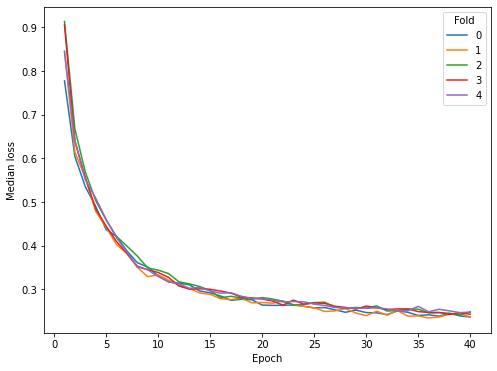

In [5]:
plt.figure(figsize=(8, 6))

for i in range(5):
    plt.plot(
        stats[stats['model'] == 'multiunet_{}'.format(i)]['epoch'],
        stats[stats['model'] == 'multiunet_{}'.format(i)]['train_loss_second'],
        label='{}'.format(i)
    )

plt.xlabel('Epoch')
plt.ylabel('Median loss')
plt.legend(title='Fold')
plt.show()

## Sample

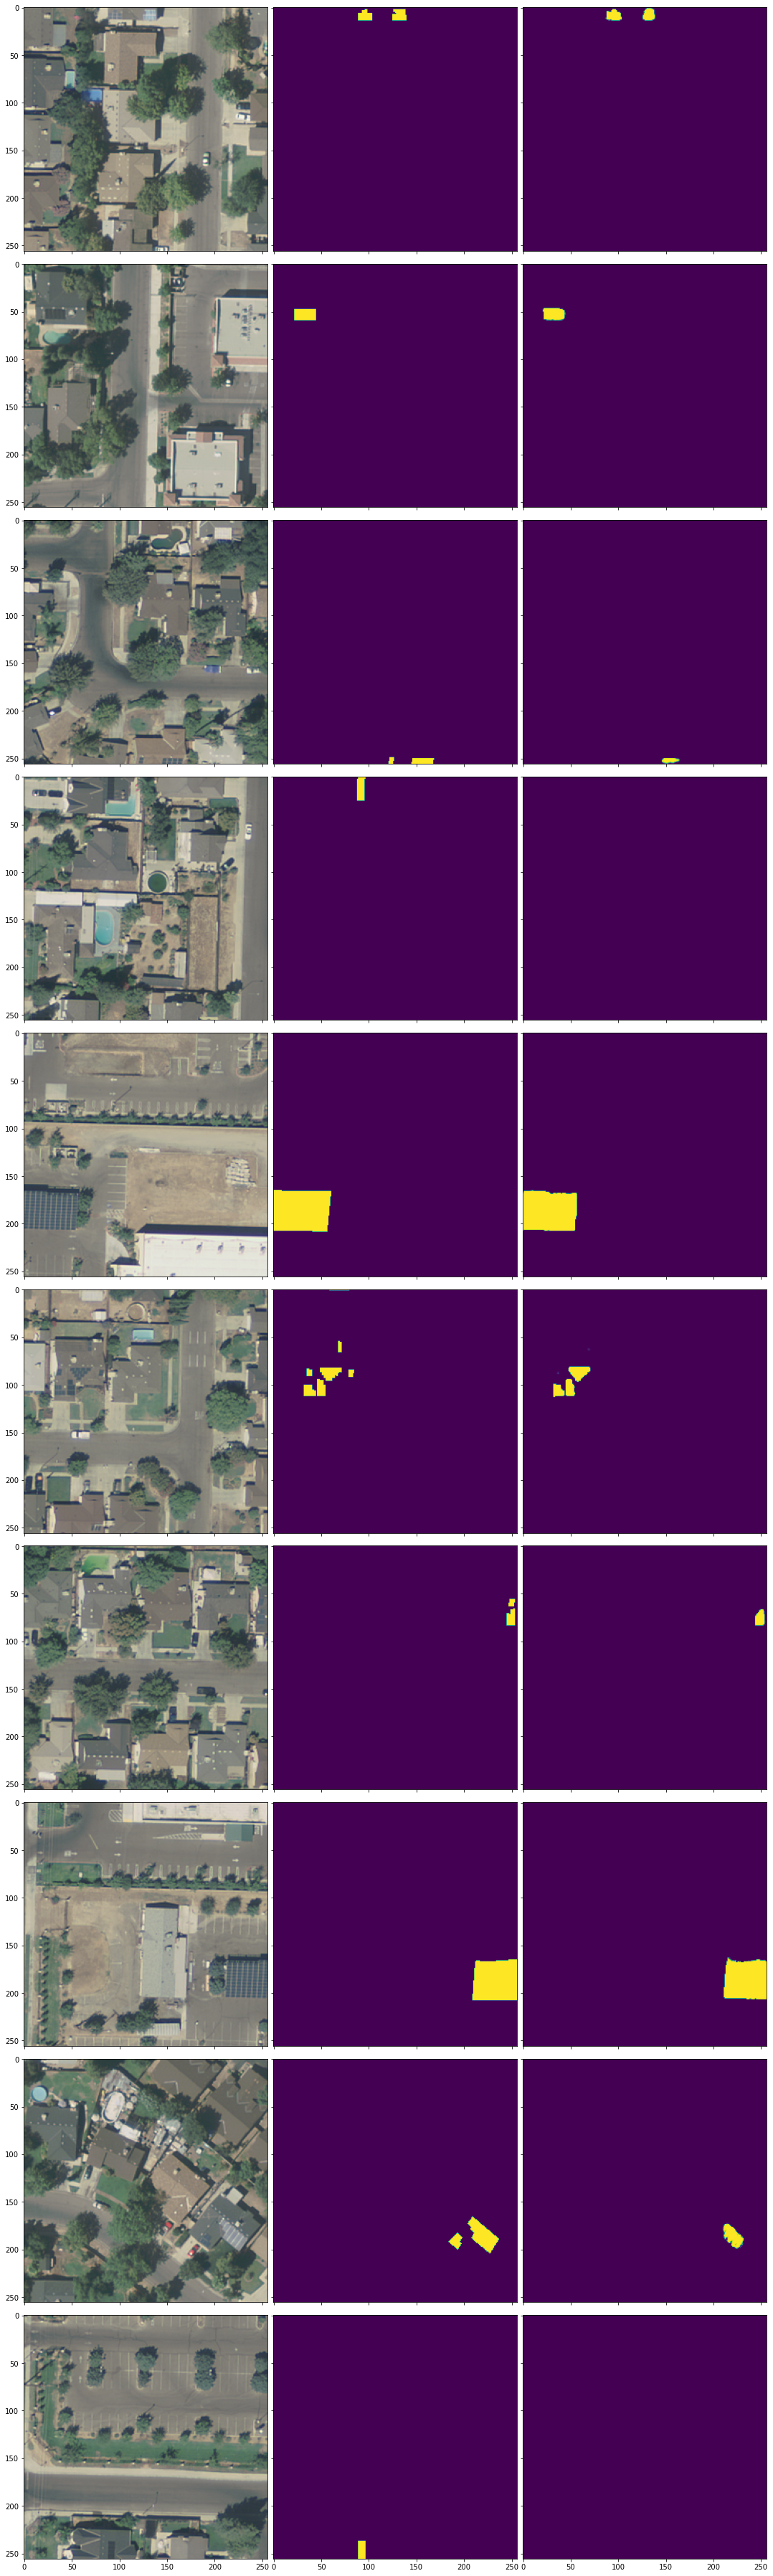

In [6]:
from dataset import to_pil
from plots import plot_alongside

model.eval()

with torch.no_grad():
    for inputs, targets in validloader:
        break

    outputs = model(inputs.to(device)).cpu()

plot_alongside(
    map(to_pil, inputs),
    map(to_pil, targets),
    map(to_pil, outputs),
    zoom=5
)

plt.tight_layout()